In [39]:
import numpy as np
from math import log, pi
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_array, check_X_y, check_is_fitted

class RBFKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting.

    Parameters
    ----------
    k : int, default=sqrt(n_training_samples)
        Number of neighbors to consider.
    h : float, default=\frac{e^{-1}}{mean(dist_training_samples)^{-2}+mean(dist_training_samples)^{-1/2}}
        Radius (std. deviation) of the isotropic RBF (covariance = h^2 * I).
    """
    def __init__(self, k: int | None = None, h: float | None = None):
        self.k = k
        self.h = h

    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_min_samples=1, dtype=float)

        n_samples, n_features = X.shape

        # default k: sqrt(n_samples)
        if self.k is None:
            self.k = int(np.floor(np.sqrt(n_samples)))

        # default h: based on average pairwise distance in training set
        if self.h is None:
            # compute average pairwise distance (inefficient for large n_samples)
            dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
            mean_dist = np.sum(dists) / (n_samples * (n_samples - 1))  # exclude self-distances
            self.h = np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5)


        if self.h <= 0:
            raise ValueError("h must be > 0 (standard deviation of RBF).")
        
        k_eff = min(max(1, self.k), n_samples)

        # store data
        self.X_ = X.copy()
        self.y_ = np.asarray(y).copy()
        self.n_features_in_ = n_features

        # classes and integer-encoded labels
        self.classes_, inv = np.unique(self.y_, return_inverse=True)
        self._y_encoded = inv  # length n_samples, values in [0, n_classes-1]
        self.n_classes_ = self.classes_.shape[0]

        # nearest-neighbor structure
        self._k_eff = k_eff
        self._nn = NearestNeighbors(n_neighbors=self._k_eff)
        self._nn.fit(self.X_)

        return self

    def _rbf_logpdf_const(self):
        # constant term of isotropic multivariate normal log-pdf
        d = self.n_features_in_
        return -0.5 * d * (np.log(2 * pi) + np.log(self.h * self.h))

    def predict_proba(self, X):
        check_is_fitted(self, attributes=['X_', 'y_', '_nn'])
        X = check_array(X, dtype=float)
        n_test = X.shape[0]

        # get k nearest neighbors (distances returned in Euclidean norm)
        dists, idxs = self._nn.kneighbors(X, n_neighbors=self._k_eff, return_distance=True)
        # dists shape (n_test, k), idxs same shape
        dists_sq = dists ** 2  # squared euclidean distances

        # compute log-weights for each neighbor: logpdf of N(mu=neighbor, cov=h^2 I)
        const = self._rbf_logpdf_const()
        logw = const - 0.5 * (dists_sq / (self.h * self.h))  # shape (n_test, k)

        # numerical stabilization: subtract max per row before exponentiation
        max_logw = np.max(logw, axis=1, keepdims=True)
        stable_w = np.exp(logw - max_logw)  # now safe to exponentiate

        # accumulate weighted votes per class
        probs = np.zeros((n_test, self.n_classes_), dtype=float)
        neighbor_classes = self._y_encoded[idxs]  # shape (n_test, k)

        # vectorized accumulation per sample using bincount (loop over tests)
        for i in range(n_test):
            w = stable_w[i]
            cls_idx = neighbor_classes[i]
            # sum weights for each class among neighbors
            counts = np.bincount(cls_idx, weights=w, minlength=self.n_classes_)
            probs[i, :] = counts

        # normalize to probabilities
        row_sums = probs.sum(axis=1, keepdims=True)
        # if any row sums are zero (unlikely due to stabilization), assign uniform over neighbor classes
        zero_mask = (row_sums.squeeze() == 0)
        if zero_mask.any():
            for i in np.nonzero(zero_mask)[0]:
                present = np.unique(neighbor_classes[i])
                probs[i, :] = 0.0
                probs[i, present] = 1.0 / present.size
            row_sums = probs.sum(axis=1, keepdims=True)

        probs /= row_sums
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [40]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)
clf = RBFKNeighborsClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))
probs = clf.predict_proba(X_test[:5])
print("Probs for first 5 test samples:\n", probs)


Accuracy: 0.9736842105263158
Probs for first 5 test samples:
 [[0.         0.06962706 0.93037294]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]]


Test accuracy: 0.9273  (k=13, h=0.3469924031835624)


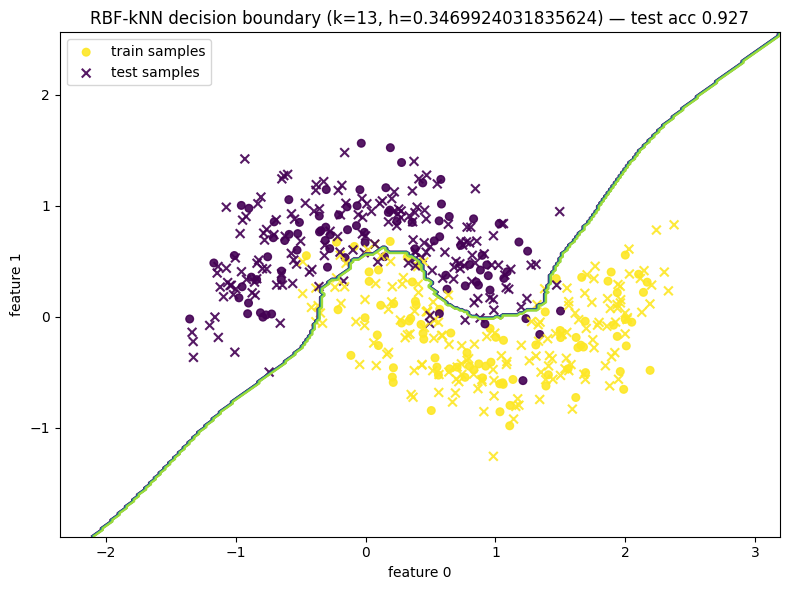

In [41]:
"""
Example: RBF-weighted k-NN on the Moons dataset with DecisionBoundaryDisplay.

Requirements
------------
- numpy
- matplotlib
- scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# --- Configuration ---
k = None         # number of neighbors - use default sqrt(n_samples)
h = None         # RBF radius (std. dev.) - use default based on training set
random_state = 0
n_samples = 500
noise = 0.25

# --- Prepare data ---
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.66, stratify=y, random_state=random_state
)

# --- Build pipeline: scaling + classifier ---
clf = RBFKNeighborsClassifier(k=k, h=h)  # use your implementation
pipe = make_pipeline(StandardScaler(), clf)

# --- Fit and evaluate ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)
print(f"Test accuracy: {acc:.4f}  (k={pipe.named_steps['rbfkneighborsclassifier'].k}, h={pipe.named_steps['rbfkneighborsclassifier'].h})")

# --- Decision boundary visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# DecisionBoundaryDisplay will plot the decision function (here we use predict)
# The 'from_estimator' helper handles creating the mesh and plotting contours.
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,                # bounds are derived from these points
    response_method="predict",
    plot_method="contour",
    ax=ax,
    grid_resolution=300,
    
)

# Overlay training points (color-coded by class)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)

ax.set_title(f"RBF-kNN decision boundary (k={pipe.named_steps['rbfkneighborsclassifier'].k}, h={pipe.named_steps['rbfkneighborsclassifier'].h}) — test acc {acc:.3f}")
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()
